Uploaded the zip file of the Dataset. Extracting the same.

In [23]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import expon


# Extract the uploaded zip file
zip_file_path = "/Datasets.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extracts to a "Datasets" folder

# Set the base path to the extracted folder
base_path = "/content"


Task 1: Compute the Missing rainfall data for all the 4 Rain gauge locations. The output file named Filled_Rainfall_Data.xlsx is generated with the results.

In [24]:
import pandas as pd

# Define the path to the rainfall file
rainfall_file = "/content/Datasets/Rainfall and Runoff Dataset.xlsx"

try:
    # Load the dataset with multi-level headers
    df = pd.read_excel(rainfall_file, sheet_name="Rainfall_flow_level", header=[0, 1])

    # Display the dataset's columns for debugging
    print("Available columns in the dataset before cleaning:", df.columns.tolist())

    # Clean column names: Use only the first level if the second level is "Unnamed"
    df.columns = [
        col[0] if "Unnamed" in col[1] else f"{col[0]} {col[1]}".strip()
        for col in df.columns
    ]

    # Display the cleaned dataset's columns
    print("Available columns in the dataset after cleaning:", df.columns.tolist())

    # Drop the columns from the DataFrame
    # Remove the specified columns
    columns_to_remove = [
        'Water level (m) Station',
        'Water level (m) Latitude',
        'Water level (m) Longitude'
    ]
    df_final = df.drop(columns=columns_to_remove, errors='ignore')
    print("Columns after dropping specified columns:", df_final.columns.tolist())

    # Check for missing values in the rain gauge columns
    rain_gauge_columns = ["Rainfall in mm Station 1", "Rainfall in mm Station 2", "Rainfall in mm Station 3", "Rainfall in mm Station4"]
    print("Missing values in the rain gauge columns before filling:")
    print(df[rain_gauge_columns].isnull().sum())

    # Fill missing rainfall data in rain gauge columns using interpolation (or any method of your choice)
    for station in rain_gauge_columns:
        if station in df.columns:
            df[station] = df[station].interpolate(method="linear").bfill().ffill()

    # Check for missing values after filling
    print("Missing values in the rain gauge columns after filling:")
    print(df[rain_gauge_columns].isnull().sum())

    # Save the cleaned and updated DataFrame to a new Excel file
    output_file = "/content/Filled_Rainfall_Data.xlsx"
    df_final.to_excel(output_file, index=False)
    print(f"Task 1: Missing rainfall data filled and cleaned data saved to '{output_file}'.")

except Exception as e:
    print(f"An error occurred: {e}")


Available columns in the dataset before cleaning: [('Date ', 'Unnamed: 0_level_1'), ('Rainfall in mm', 'Station 1'), ('Rainfall in mm', 'Station 2'), ('Rainfall in mm', 'Station 3'), ('Rainfall in mm', 'Station4'), ('Discharge (cumecs)', 'Unnamed: 5_level_1'), ('Water level (m)', 'Unnamed: 6_level_1'), ('Water level (m)', 'Unnamed: 7_level_1'), ('Water level (m)', 'Station'), ('Water level (m)', 'Latitude'), ('Water level (m)', 'Longitude')]
Available columns in the dataset after cleaning: ['Date ', 'Rainfall in mm Station 1', 'Rainfall in mm Station 2', 'Rainfall in mm Station 3', 'Rainfall in mm Station4', 'Discharge (cumecs)', 'Water level (m)', 'Water level (m)', 'Water level (m) Station', 'Water level (m) Latitude', 'Water level (m) Longitude']
Columns after dropping specified columns: ['Date ', 'Rainfall in mm Station 1', 'Rainfall in mm Station 2', 'Rainfall in mm Station 3', 'Rainfall in mm Station4', 'Discharge (cumecs)', 'Water level (m)', 'Water level (m)']
Missing values in

Task 2: Calculate basin rainfall from the historical rainfall data of 4 gauges with the basin shapefile provided. The output file named Basin_Rainfall.xlsx and Spatially_Integrated_Basin_Rainfall.xlsx is generated with the results.

In [25]:
import geopandas as gpd
import pandas as pd

# Define file paths
shapefile_path = "/content/Datasets/Basin_Case Study"
shapefile = "/content/Datasets/Basin_Case Study/Basin_Case_Study.shp"
rainfall_file = "/content/Filled_Rainfall_Data.xlsx"

try:
    # Load shapefile
    gdf = gpd.read_file(shapefile)
    print("Shapefile loaded successfully.")

    # Load rainfall dataset
    df = pd.read_excel(rainfall_file)

    # Display dataset columns for debugging
    print("Columns in the dataset:", df.columns.tolist())

    # Match station columns by name
    rain_gauge_columns = ["Rainfall in mm Station 1", "Rainfall in mm Station 2", "Rainfall in mm Station 3", "Rainfall in mm Station4"]

    # Ensure columns exist in the DataFrame
    for col in rain_gauge_columns:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in the dataset.")

    # Calculate basin rainfall (e.g., simple average)
    df["Basin Rainfall"] = df[rain_gauge_columns].mean(axis=1)

    # Drop unwanted column (assuming it's column H)
    # If column H is unnamed, you can drop it by index. Column H corresponds to index 7 (0-based indexing)
    df = df.drop(df.columns[7], axis=1)  # Drop column at index 7 (H)

    # Save the result
    output_file = "/content/Basin_Rainfall.xlsx"
    df.to_excel(output_file, index=False)
    print(f"Task 2: Basin rainfall calculated and saved to '{output_file}'.")

except Exception as e:
    print(f"An error occurred: {e}")


Shapefile loaded successfully.
Columns in the dataset: ['Date ', 'Rainfall in mm Station 1', 'Rainfall in mm Station 2', 'Rainfall in mm Station 3', 'Rainfall in mm Station4', 'Discharge (cumecs)', 'Water level (m)', 'Water level (m).1']
Task 2: Basin rainfall calculated and saved to '/content/Basin_Rainfall.xlsx'.


In [26]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Define file paths
shapefile_path = "/content/Datasets/Basin_Case Study/Basin_Case_Study.shp"
rainfall_file = "/content/Filled_Rainfall_Data.xlsx"

# Define rain gauge locations
rain_gauge_locations = {
    "Station 1": {"latitude": 10.15, "longitude": 76.75},
    "Station 2": {"latitude": 10.09139, "longitude": 76.68833},
    "Station 3": {"latitude": 9.722167, "longitude": 77.15222},
    "Station 4": {"latitude": 10.15917, "longitude": 76.61639},
}

# Load the shapefile
basin_gdf = gpd.read_file(shapefile_path)
print("Basin shapefile loaded successfully.")

# Convert rain gauge data to a GeoDataFrame
gauge_df = pd.DataFrame(rain_gauge_locations).T.reset_index()
gauge_df.columns = ["Station", "latitude", "longitude"]
gauge_gdf = gpd.GeoDataFrame(
    gauge_df,
    geometry=gpd.points_from_xy(gauge_df.longitude, gauge_df.latitude),
    crs="EPSG:4326",  # Use WGS84 (latitude/longitude)
)
print("Rain gauge GeoDataFrame created.")

# Ensure shapefile and rain gauges are in the same CRS
basin_gdf = basin_gdf.to_crs(gauge_gdf.crs)

# Spatial join to assign gauges to the basin
gauge_within_basin = gpd.sjoin(gauge_gdf, basin_gdf, how="inner", predicate="intersects")
print(f"Stations within the basin: {gauge_within_basin['Station'].tolist()}")


# Load rainfall dataset
rainfall_df = pd.read_excel(rainfall_file)

# Match station columns by name (ensure names align with rainfall dataset)
rain_gauge_columns = [
    "Rainfall in mm Station 1",
    "Rainfall in mm Station 2",
    "Rainfall in mm Station 3",
    "Rainfall in mm Station4",
]

# Calculate basin rainfall (spatially weighted average)
# Assign equal weights as a placeholder. Replace with actual weights if available.
gauge_within_basin["weight"] = 1 / len(gauge_within_basin)

# Normalize weights to sum to 1
gauge_within_basin["weight"] /= gauge_within_basin["weight"].sum()

# Mapping from rain gauge columns to Station names
station_mapping = {
    "Rainfall in mm Station 1": "Station 1",
    "Rainfall in mm Station 2": "Station 2",
    "Rainfall in mm Station 3": "Station 3",
    "Rainfall in mm Station4": "Station 4",
}

# Compute weighted rainfall for each time step
rainfall_df["Basin Rainfall"] = 0  # Initialize the column

for col in rain_gauge_columns:
    station_name = station_mapping[col]  # Map to corresponding Station name
    weight = gauge_within_basin.loc[
        gauge_within_basin["Station"] == station_name, "weight"
    ].values[0]

    # Add the weighted contribution to the Basin Rainfall column
    rainfall_df["Basin Rainfall"] += rainfall_df[col] * weight


# Save the result to a new Excel file
output_file = "/content/Spatially_Integrated_Basin_Rainfall.xlsx"
rainfall_df.to_excel(output_file, index=False)
print(f"Spatially integrated basin rainfall saved to '{output_file}'.")


Basin shapefile loaded successfully.
Rain gauge GeoDataFrame created.
Stations within the basin: ['Station 1', 'Station 2', 'Station 3', 'Station 4']
Spatially integrated basin rainfall saved to '/content/Spatially_Integrated_Basin_Rainfall.xlsx'.


Task 3: Create a rating curve for the discharge and water level data provided. A Rating_Curve.png is generated.

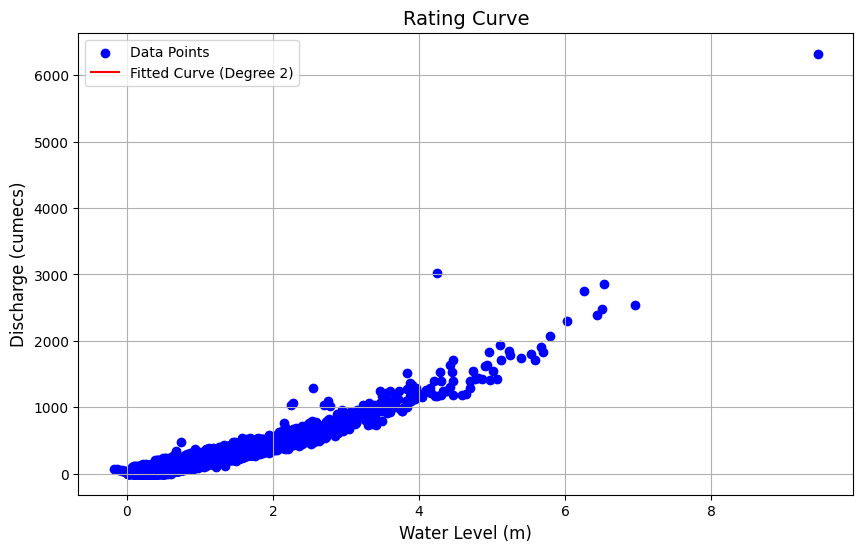

Task 3: Rating curve plotted and saved as 'Rating_Curve.png'.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import Polynomial

# Load the dataset
file_path = "/content/Basin_Rainfall.xlsx"
df = pd.read_excel(file_path)

# Extract relevant columns
water_level = df['Water level (m)']
discharge = df['Discharge (cumecs)']

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(water_level, discharge, color='blue', label='Data Points')

# Fit a regression line (e.g., a polynomial of degree 2)
degree = 2  # Adjust the degree as needed
poly = Polynomial.fit(water_level, discharge, deg=degree)
x_line = np.linspace(water_level.min(), water_level.max(), 100)
y_line = poly(x_line)

# Plot the fitted curve
plt.plot(x_line, y_line, color='red', label=f'Fitted Curve (Degree {degree})')

# Enhance plot aesthetics
plt.xlabel("Water Level (m)", fontsize=12)
plt.ylabel("Discharge (cumecs)", fontsize=12)
plt.title("Rating Curve", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# Save the plot as an image
output_file = "Rating_Curve.png"
plt.savefig(output_file, dpi=300)
plt.show()

# Confirmation message
print(f"Task 3: Rating curve plotted and saved as '{output_file}'.")


Task 4: Used interpolation to estimate the missing discharges.

In [28]:
# Load the dataset
file_path = "/content/Spatially_Integrated_Basin_Rainfall.xlsx"
df = pd.read_excel(file_path)

# Simple estimation using interpolation
df['Discharge (cumecs)'] = df['Discharge (cumecs)'].interpolate().bfill().ffill()
df.to_excel("Estimated_Discharge.xlsx", index=False)
print("Task 4: Missing discharges estimated and saved to 'Estimated_Discharge.xlsx'.")


Task 4: Missing discharges estimated and saved to 'Estimated_Discharge.xlsx'.


Task 5: For the given time series discharge data, calculate the probability of exceedance of flows over 1 TMC, 2 TMC, 5 TMC, 10 TMC every day.

In [29]:
import pandas as pd

# Load the dataset
file_path = "/content/Estimated_Discharge.xlsx"
df = pd.read_excel(file_path)

# Given flow thresholds for 1 TMC, 2 TMC, 5 TMC, 10 TMC over a 24-hour period
flow_thresholds = [327.56, 655.12, 1637.8, 3275.6]
total_flows = len(df['Discharge (cumecs)'])  # Total number of discharge data points

# Dictionary to store exceedance probabilities for each threshold
exceedance = {}

# Loop through the thresholds and calculate the probability of exceedance
for threshold in flow_thresholds:
    # Count how many values exceed the threshold
    exceedance[threshold] = (df['Discharge (cumecs)'] > threshold).sum() / total_flows * 100

# Output the calculated probabilities of exceedance
print("Task 5: Probability of exceedance:", exceedance)

# Convert the exceedance dictionary to a DataFrame for export
exceedance_df = pd.DataFrame(list(exceedance.items()), columns=["Flow Threshold (cumecs)", "Exceedance Probability (%)"])

# Define the output file path
output_file = "/content/Exceedance_Probabilities.xlsx"

# Save the results to an Excel file
exceedance_df.to_excel(output_file, index=False)
print(f"Exceedance probabilities saved to '{output_file}'.")


Task 5: Probability of exceedance: {327.56: 20.82982308340354, 655.12: 5.560235888795282, 1637.8: 0.4633529907329402, 3275.6: 0.02106149957877001}
Exceedance probabilities saved to '/content/Exceedance_Probabilities.xlsx'.


Task 6: Developed a rainfall-runoff relationship using Polynomial Regression and indicated what percent of variation in runoff is accounted by the proposed equation.


In [30]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = "/content/Estimated_Discharge.xlsx"
df = pd.read_excel(file_path)

# Impute missing values in relevant columns with the mean
imputer = SimpleImputer(strategy='mean')
df['Basin Rainfall'] = imputer.fit_transform(df[['Basin Rainfall']])
df['Discharge (cumecs)'] = imputer.fit_transform(df[['Discharge (cumecs)']])

# Extract relevant columns
rainfall = df['Basin Rainfall'].values.reshape(-1, 1)  # Reshape to 2D array
runoff = df['Discharge (cumecs)']

# Fit linear regression
linear_model = LinearRegression()
linear_model.fit(rainfall, runoff)

# Calculate R² score for linear regression
linear_r_squared = linear_model.score(rainfall, runoff)
print(f"R² Score (Linear Regression): {linear_r_squared:.2f}")

# Polynomial features (degree 2, adjust the degree as needed)
poly = PolynomialFeatures(degree=2)
rainfall_poly = poly.fit_transform(rainfall)

# Fit polynomial regression
polynomial_model = LinearRegression()
polynomial_model.fit(rainfall_poly, runoff)

# Calculate R² score for polynomial regression
polynomial_r_squared = polynomial_model.score(rainfall_poly, runoff)
print(f"R² Score (Polynomial Regression): {polynomial_r_squared:.2f}")

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Polynomial Regression (Degree 2)"],
    "R² Score": [linear_r_squared, polynomial_r_squared]
})

# Define the output file path
output_file = "/content/Regression_R2_Score.xlsx"

# Save the results to an Excel file
results_df.to_excel(output_file, index=False)
print(f"R² Scores saved to '{output_file}'.")


R² Score (Linear Regression): 0.43
R² Score (Polynomial Regression): 0.44
R² Scores saved to '/content/Regression_R2_Score.xlsx'.


Task 7: Perform flood frequency analysis based on the data provided. Assuming the current year reported a flow of magnitude equal to 5000 cumecs, report the likely return period of the given flood event from the analysis performed.

In [31]:
import pandas as pd
from scipy.stats import genextreme

# Load the dataset
file_path = "/content/Estimated_Discharge.xlsx"
df = pd.read_excel(file_path)

peak_flows = df['Discharge (cumecs)']

# Fit the GEV distribution to your peak flows
params = genextreme.fit(peak_flows)

# Calculate the return period for 5000 cumecs
return_period_gev = 1 / (1 - genextreme.cdf(5000, *params))
print(f"Return period for 5000 cumecs flood using GEV: {return_period_gev:.2f} years")

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Flood Magnitude (cumecs)": [5000],
    "Return Period (years)": [return_period_gev]
})

# Define the output file path
output_file = "/content/GEV_Flood_Return_Period.xlsx"

# Save the results to an Excel file
results_df.to_excel(output_file, index=False)
print(f"Return period for 5000 cumecs flood using GEV saved to '{output_file}'.")


Return period for 5000 cumecs flood using GEV: 420.41 years
Return period for 5000 cumecs flood using GEV saved to '/content/GEV_Flood_Return_Period.xlsx'.


Task 8: Calculate 25%, 50%, 75% Dependability Discharge from the stream flow time series provided.

In [32]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "/content/Estimated_Discharge.xlsx"
df = pd.read_excel(file_path)

# Calculate the dependability discharges at 25%, 50%, and 75%
percentiles = [25, 50, 75]
dependability = np.percentile(df['Discharge (cumecs)'], percentiles)

# Print the results
print(f"Task 8: Dependability discharges at 25%, 50%, and 75%:", dependability)

# Create a DataFrame to store the results
dependability_df = pd.DataFrame({
    "Percentile": percentiles,
    "Dependability Discharge (cumecs)": dependability
})

# Define the output file path
output_file = "/content/Dependability_Discharge_Results.xlsx"

# Save the results to an Excel file
dependability_df.to_excel(output_file, index=False)
print(f"Dependability discharges saved to '{output_file}'.")


Task 8: Dependability discharges at 25%, 50%, and 75%: [ 50.  134.1 291.7]
Dependability discharges saved to '/content/Dependability_Discharge_Results.xlsx'.


Given Observed and Modelled data time series, find the performance metrics between them by coding.

In [33]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define file path for the dataset
file_path = "/content/Datasets/Performance_assessment.xlsx"

# Load the dataset
df = pd.read_excel(file_path)

# Map columns to observed and modeled variables
observed = df['Obs']  # Observed discharge
modeled = df['Simulated']  # Simulated discharge

# Calculate performance metrics
mse = mean_squared_error(observed, modeled)
mae = mean_absolute_error(observed, modeled)
rmse = np.sqrt(mse)
r2 = r2_score(observed, modeled)

# Print performance metrics
print(f"Performance Metrics:")
print(f"MSE = {mse}")
print(f"MAE = {mae}")
print(f"RMSE = {rmse}")
print(f"R² = {r2}")

# Create a DataFrame to store the results
metrics_df = pd.DataFrame({
    "Metric": ["MSE", "MAE", "RMSE", "R²"],
    "Value": [mse, mae, rmse, r2]
})

# Define the output file path
output_file = "/content/Performance_Metrics_Results.xlsx"

# Save the performance metrics to an Excel file
metrics_df.to_excel(output_file, index=False)
print(f"Performance metrics saved to '{output_file}'.")


Performance Metrics:
MSE = 126729.35804835924
MAE = 200.1908462867012
RMSE = 355.99067129400913
R² = 0.6155601392849028
Performance metrics saved to '/content/Performance_Metrics_Results.xlsx'.


Perform mass balance, given timeseries data of inflows, outflows, and storage details of a reservoir. The output is saved in xlsx format named as Mass_Balance_Results.

In [34]:
import pandas as pd

# Load the dataset and skip metadata rows
file_path = "/content/Datasets/Dataset for Mass balance case study.xlsx"
reservoir_data = pd.read_excel(file_path, skiprows=4)

# Rename columns for clarity
reservoir_data.columns = [
    'Date', 'Level (m)', 'Storage (TMC)', 'Tributary 1 (cusecs)', 'Tributary 2 (cusecs)', 'Inflow (cusecs)', 'Outflow (cusecs)',
    'Spillway (cusecs)', 'Canal 1 (cusecs)', 'Canal 2 (cusecs)',
    'Canal 3 (cusecs)', 'Canal 4 (cusecs)', 'Canal 5 (cusecs)', 'Losses (cusecs)'
]

# Extract relevant columns for mass balance calculation
reservoir_data = reservoir_data[['Date', 'Inflow (cusecs)', 'Outflow (cusecs)', 'Storage (TMC)']]

# Convert storage from TMC to cusecs (1 TMC = 1e9 cubic feet)
# For daily conversion: 1 TMC/day = 1e9 cubic feet / 86400 seconds
reservoir_data['Storage (cusecs)'] = (reservoir_data['Storage (TMC)'] * 1e9) / 86400

# Calculate change in storage (∆Storage) in cusecs
reservoir_data['Change in Storage (cusecs)'] = reservoir_data['Storage (cusecs)'].diff().fillna(0)

# Perform mass balance calculation in cusecs
reservoir_data['Mass Balance (cusecs)'] = (
    reservoir_data['Inflow (cusecs)']
    - reservoir_data['Outflow (cusecs)']
    - reservoir_data['Change in Storage (cusecs)']
)

# Save the results to a new Excel file
output_file = "Mass_Balance_Results.xlsx"
reservoir_data.to_excel(output_file, index=False)

print(f"Mass balance calculations saved to '{output_file}'.")


Mass balance calculations saved to 'Mass_Balance_Results.xlsx'.


<ipython-input-34-9545d6a7eb09>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reservoir_data['Storage (cusecs)'] = (reservoir_data['Storage (TMC)'] * 1e9) / 86400


Calculated Design storms of 24 hour duration with the Rainfall data provided.The outputs are saved in xlsx format for all the 9 stations.

In [35]:
import os
import pandas as pd

# Path to the directory containing the Design Storm data
design_storm_path = "/content/Datasets/Design Storm_Case Study"
design_storm_data = {}

# Loop through each file in the directory
for file in os.listdir(design_storm_path):
    if file.endswith(".txt"):
        # Extract station name from file name
        station_name = file.replace(".txt", "")

        # Open and read the file
        with open(os.path.join(design_storm_path, file), 'r') as f:
            lines = f.readlines()

        # Extract the tabular data starting from the appropriate line
        start_index = 7  # Tabular data starts at line 7
        tabular_data = lines[start_index:]

        # Parse the data into a DataFrame
        data = []
        for line in tabular_data:
            parts = line.strip().split('/')
            if len(parts) == 2:
                time_part = parts[0].strip()
                rainfall_part = parts[1].split(':')[-1].strip()
                try:
                    rainfall_value = float(rainfall_part)
                    data.append([time_part, rainfall_value])
                except ValueError:
                    print(f"Error parsing rainfall value in file {file}: {rainfall_part}")

        # Convert to a DataFrame
        df = pd.DataFrame(data, columns=["Time (hours)", "Rainfall (mm)"])

        # Store the DataFrame in the dictionary
        design_storm_data[station_name] = df

# Process and save the data
for station, data in design_storm_data.items():
    # Ensure there is enough data (at least 24 hours)
    if len(data) >= 24:
        total_storms = len(data) - 23  # Number of 24-hour storms (each starting from hour 1 to hour 24)
        storm_totals = []
        storm_intensities = []

        # Calculate total rainfall for each 24-hour period
        for i in range(total_storms):
            # Select the 24-hour block
            storm_data = data.iloc[i:i+24]

            # Calculate total rainfall for this 24-hour period
            total_rainfall = storm_data['Rainfall (mm)'].sum()
            storm_totals.append(total_rainfall)

            # Calculate the average intensity (total rainfall / 24)
            average_intensity = total_rainfall / 24
            storm_intensities.append(average_intensity)

        # Output the total rainfall and average intensity for each 24-hour period
        for i in range(len(storm_totals)):
            print(f"Design Storm {i+1} for {station}: Total Rainfall = {storm_totals[i]:.2f} mm, Average Intensity = {storm_intensities[i]:.2f} mm/hour")

        # Save the storm totals and intensities to an Excel file
        result_df = pd.DataFrame({
            "Storm Period": [f"Design Storm {i+1}" for i in range(len(storm_totals))],
            "Total Rainfall (mm)": storm_totals,
            "Average Intensity (mm/hour)": storm_intensities
        })

        result_df.to_excel(f"Design_Storm_{station}_24hr_Design_Storms.xlsx", index=False, float_format="%.2f")
    else:
        print(f"Warning: Data for station {station} is incomplete (less than 24 hours).")


KeyboardInterrupt: 